# [第9章: RNN, CNN](https://nlp100.github.io/ja/ch09.html)

## [80. ID番号への変換](https://nlp100.github.io/ja/ch09.html#80-id%E7%95%AA%E5%8F%B7%E3%81%B8%E3%81%AE%E5%A4%89%E6%8F%9B)
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に`1`，2番目に頻出する単語に`2`，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて`0`とせよ．

In [1]:
!ls Output/Chapter06/*.feature.txt

Output/Chapter06/test.feature.txt   Output/Chapter06/valid.feature.txt
Output/Chapter06/train.feature.txt


In [2]:
from operator import itemgetter

In [3]:
def create_word2count():
    word2count = {}
    once_words = set()

    def _create_word2count_file(f):
        for line in f:
            words = line.replace("\n", "").split("\t")[1].split()
            for word in words:
                if word in word2count:
                    word2count[word] += 1
                elif word in once_words:
                    word2count[word] = 2
                    once_words.remove(word)
                else:
                    once_words.add(word)

    with open("Output/Chapter06/train.feature.txt") as f:
        _create_word2count_file(f)

    with open("Output/Chapter06/valid.feature.txt") as f:
        _create_word2count_file(f)

    with open("Output/Chapter06/test.feature.txt") as f:
        _create_word2count_file(f)

    word2count_sorted = sorted(word2count.items(), reverse=True, key=itemgetter(1,0))
    return {k: v for k, v in word2count_sorted}

In [4]:
word2count = create_word2count()

In [5]:
def sentence2ids(sentence: str):
    return [list(word2count.keys()).index(word) + 1 if word in word2count else 0
            for word in sentence.split()]

In [6]:
# Test
sentence2ids("updat 2-at&t threaten sit US spectrum auction rule")

[3, 0, 999, 2390, 5, 6330, 1098, 163]

## [81. RNNによる予測](https://nlp100.github.io/ja/ch09.html#81-rnn%E3%81%AB%E3%82%88%E3%82%8B%E4%BA%88%E6%B8%AC)
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．
$$
\overrightarrow{h}_0 = 0, \overrightarrow{h}_t = \overrightarrow{\mathrm{RNN}}(\mathrm{emb}(x_t), \overrightarrow{h}_{t-1}), y = \mathrm{softmax}(W^{(yh)} \overrightarrow{h}_T + b^{(y)})
$$
ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow{h}_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，$\overrightarrow{\mathrm{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット$\overrightarrow{\mathrm{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．
$$
\overrightarrow{\mathrm{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$$
ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

In [7]:
import numpy as np
import random
import torch

In [8]:
random.seed(81)
np.random.seed(81)
torch.manual_seed(81)

In [9]:
labels = ["b", "t", "e", "m"]
V = len(word2count) + 1 # +1は出現回数1回のID番号0の分を追加している
d_w = 300
d_h = 50
V

8698

In [10]:
class NewsAggregatorDataset81(torch.utils.data.Dataset):
    def __init__(self, type_str: str):
        if type_str not in ["train", "valid", "test"]:
            raise ValueError("Invalid type_str:%s" % type_str)

        in_path = "Output/Chapter06/%s.feature.txt" % type_str
        self.x_data, self.y_data = [], []

        with open(in_path) as f:
            for line in f:
                elements = line.replace("\n", "").split("\t")
                self.x_data.append(torch.tensor(sentence2ids(elements[1]),
                                                dtype=torch.int64))
                self.y_data.append(torch.tensor(labels.index(elements[0]),
                                                dtype=torch.int64))

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [11]:
%%time
dataset81_train = NewsAggregatorDataset81("train")
dataset81_valid = NewsAggregatorDataset81("valid")
dataset81_test = NewsAggregatorDataset81("test")

CPU times: user 9.96 s, sys: 18.3 ms, total: 9.98 s
Wall time: 9.95 s


In [12]:
class Network81(torch.nn.Module):
    def __init__(self):
        super(Network81, self).__init__()

        # (batch,T,V) -> (batch,T,d_w)
        self.emb = torch.nn.Embedding(num_embeddings=V,
                                      embedding_dim=d_w)
        # (batch,T,d_w), (1,batch,d_h) -> (batch,T,d_h), (1,batch,d_h)
        self.rnn = torch.nn.RNN(input_size=d_w,
                                hidden_size=d_h,
                                batch_first=True)
        # (batch,d_h) -> (batch,4)
        self.affine = torch.nn.Linear(in_features=d_h,
                                      out_features=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, h0):
        # (batch,T) -> (batch,T,d_w)
        x = self.emb(x)
        # (batch,T,d_w), (1,batch,d_h) -> (batch,T,d_h), (1,batch,d_h)
        _, hn = self.rnn(x, h0)
        # (1,batch,d_h) -> (batch,d_h)
        hn = torch.squeeze(hn, 0)
        # (batch,d_h) -> (batch,4)
        x = self.affine(hn)
        return self.log_softmax(x)

In [13]:
network81 = Network81()

In [14]:
for x_in, _ in torch.utils.data.DataLoader(dataset81_test, batch_size=1):
    h0 = torch.zeros(1, 1, d_h)
    x_out = network81(x_in, h0)
    y = torch.exp(x_out)
    print(y)
    break

tensor([[0.3053, 0.2050, 0.3143, 0.1754]], grad_fn=<ExpBackward>)


## [82. 確率的勾配降下法による学習](https://nlp100.github.io/ja/ch09.html#82-%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95%E3%81%AB%E3%82%88%E3%82%8B%E5%AD%A6%E7%BF%92)
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [16]:
random.seed(82)
np.random.seed(82)
torch.manual_seed(82)

In [17]:
%matplotlib inline

In [18]:
sns.set(style="darkgrid", context="notebook", palette="muted")

In [19]:
network82, epoch, lr = Network81(), 10, 0.05
loader82_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=1,
                                             shuffle=True)
loader82_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [20]:
%%time
result82 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network82.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader82_train:
        network82.zero_grad()
        h0 = torch.zeros(1, 1, d_h)
        x_out = network82(x_in, h0)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result82["Epoch"].append(e)
    result82["Type"].append("Training")
    result82["Loss"].append(loss_sum)
    result82["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader82_valid:
        network82.zero_grad()
        h0 = torch.zeros(1, 1, d_h)
        x_out = network82(x_in, h0)
        loss = criterion(x_out, y)

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result82["Epoch"].append(e)
    result82["Type"].append("Validation")
    result82["Loss"].append(loss_sum)
    result82["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/10,Loss:1677.313,Training Accuracy:53.00%,Validation Accuracy:62.50%
Epoch:2/10,Loss:1832.675,Training Accuracy:57.66%,Validation Accuracy:59.51%
Epoch:3/10,Loss:2100.950,Training Accuracy:60.35%,Validation Accuracy:42.22%
Epoch:4/10,Loss:1578.757,Training Accuracy:61.42%,Validation Accuracy:63.55%
Epoch:5/10,Loss:1690.090,Training Accuracy:61.39%,Validation Accuracy:60.55%
Epoch:6/10,Loss:1792.233,Training Accuracy:62.51%,Validation Accuracy:59.06%
Epoch:7/10,Loss:1791.270,Training Accuracy:60.12%,Validation Accuracy:63.17%
Epoch:8/10,Loss:1939.560,Training Accuracy:59.01%,Validation Accuracy:58.83%
Epoch:9/10,Loss:1784.198,Training Accuracy:59.59%,Validation Accuracy:53.07%
Epoch:10/10,Loss:1907.828,Training Accuracy:59.37%,Validation Accuracy:51.80%
CPU times: user 9min 54s, sys: 4.7 s, total: 9min 59s
Wall time: 9min 56s


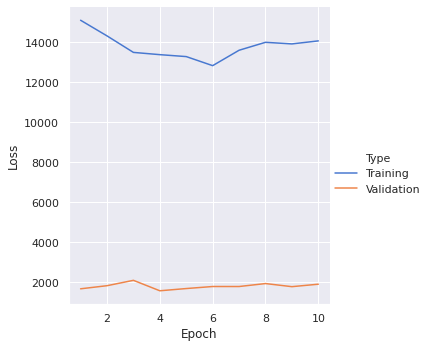

In [21]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result82))

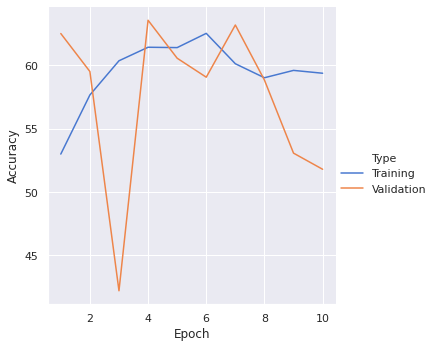

In [22]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result82))

## [83. ミニバッチ化・GPU上での学習](https://nlp100.github.io/ja/ch09.html#83-%E3%83%9F%E3%83%8B%E3%83%90%E3%83%83%E3%83%81%E5%8C%96gpu%E4%B8%8A%E3%81%A7%E3%81%AE%E5%AD%A6%E7%BF%92)
問題82のコードを改変し，$B$事例ごとに損失・勾配を計算して学習を行えるようにせよ（$B$の値は適当に選べ）．また，GPU上で学習を実行せよ．

In [23]:
torch.cuda.is_available()

True

In [24]:
random.seed(83)
np.random.seed(83)
torch.manual_seed(83)
if torch.cuda.is_available():
    torch.cuda.manual_seed(83)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [25]:
def news_aggregator_collate_fn(batch):
    x_batch = torch.nn.utils.rnn.pad_sequence([b[0] for b in batch],
                                              batch_first=True)
    y_batch = torch.tensor([b[1] for b in batch], dtype=torch.int64)

    return x_batch, y_batch

In [26]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [27]:
network83, epoch, batch_size, lr = Network81().to(device), 30, 32, 0.05
loader83_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader83_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [28]:
%%time
result83 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network83.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader83_train:
        network83.zero_grad()
        h0 = torch.zeros(1, x_in.shape[0], d_h).to(device)
        x_out = network83(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result83["Epoch"].append(e)
    result83["Type"].append("Training")
    result83["Loss"].append(loss_sum)
    result83["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader83_valid:
        network83.zero_grad()
        h0 = torch.zeros(1, 1, d_h).to(device)
        x_out = network83(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result83["Epoch"].append(e)
    result83["Type"].append("Validation")
    result83["Loss"].append(loss_sum)
    result83["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/30,Loss:1801.138,Training Accuracy:46.13%,Validation Accuracy:34.88%
Epoch:2/30,Loss:1793.971,Training Accuracy:50.86%,Validation Accuracy:36.23%
Epoch:3/30,Loss:1734.103,Training Accuracy:51.43%,Validation Accuracy:41.54%
Epoch:4/30,Loss:1750.406,Training Accuracy:53.84%,Validation Accuracy:43.04%
Epoch:5/30,Loss:1756.773,Training Accuracy:47.81%,Validation Accuracy:50.30%
Epoch:6/30,Loss:1458.255,Training Accuracy:51.57%,Validation Accuracy:62.65%
Epoch:7/30,Loss:1495.398,Training Accuracy:53.25%,Validation Accuracy:57.63%
Epoch:8/30,Loss:1527.637,Training Accuracy:48.63%,Validation Accuracy:56.66%
Epoch:9/30,Loss:1465.028,Training Accuracy:51.18%,Validation Accuracy:61.15%
Epoch:10/30,Loss:1522.287,Training Accuracy:54.65%,Validation Accuracy:58.98%
Epoch:11/30,Loss:1408.543,Training Accuracy:45.96%,Validation Accuracy:64.90%
Epoch:12/30,Loss:1793.147,Training Accuracy:51.17%,Validation Accuracy:48.73%
Epoch:13/30,Loss:1727.668,Training Accuracy:48.24%,Validation Accuracy:52

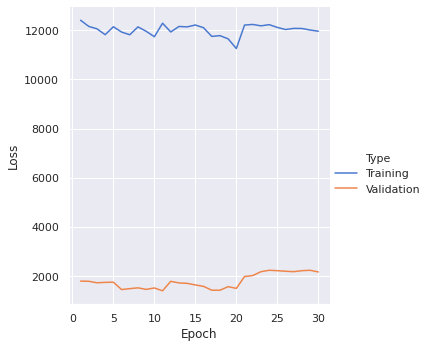

In [29]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result83))

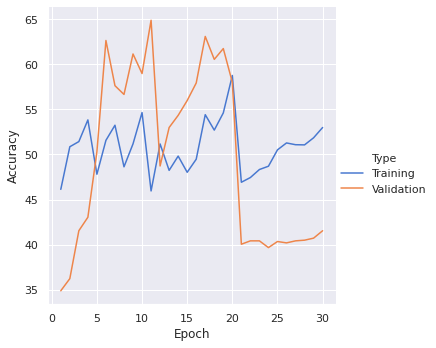

In [30]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result83))

## [84. 単語ベクトルの導入](https://nlp100.github.io/ja/ch09.html#84-%E5%8D%98%E8%AA%9E%E3%83%99%E3%82%AF%E3%83%88%E3%83%AB%E3%81%AE%E5%B0%8E%E5%85%A5)
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での[学習済み単語ベクトル](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)）で単語埋め込み$\mathrm{emb}(x)$を初期化し，学習せよ．

In [31]:
!ls Input/GoogleNews-vectors-negative300.bin

Input/GoogleNews-vectors-negative300.bin


In [32]:
!ls Output/Chapter06/*.txt | grep -v feature

Output/Chapter06/test.txt
Output/Chapter06/train.txt
Output/Chapter06/valid.txt


In [33]:
from gensim.models.keyedvectors import KeyedVectors

In [34]:
%%time
wv = KeyedVectors.load_word2vec_format("Input/GoogleNews-vectors-negative300.bin", binary=True)

CPU times: user 19.5 s, sys: 3.59 s, total: 23 s
Wall time: 33.8 s


In [35]:
random.seed(84)
np.random.seed(84)
torch.manual_seed(84)
if torch.cuda.is_available():
    torch.cuda.manual_seed(84)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [36]:
class NewsAggregatorDataset84(torch.utils.data.Dataset):
    def __init__(self, type_str: str):
        if type_str not in ["train", "valid", "test"]:
            raise ValueError("Invalid type_str:%s" % type_str)

        in_path = "Output/Chapter06/%s.txt" % type_str
        self.x_data, self.y_data = [], []

        with open(in_path) as f:
            for line in f:
                elements = line.replace("\n", "").split("\t")
                self.x_data.append(torch.tensor([wv[word] if word in wv else np.zeros(300)
                                                 for word in elements[1].split()],
                                                dtype=torch.float32))
                self.y_data.append(torch.tensor(labels.index(elements[0]),
                                                dtype=torch.int64))

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [37]:
%%time
dataset84_train = NewsAggregatorDataset84("train")
dataset84_valid = NewsAggregatorDataset84("valid")
dataset84_test = NewsAggregatorDataset84("test")

CPU times: user 5.57 s, sys: 129 ms, total: 5.7 s
Wall time: 5.75 s


In [38]:
class Network84(torch.nn.Module):
    def __init__(self):
        super(Network84, self).__init__()

        # (batch,T,d_w), (1,batch,d_h) -> (batch,T,d_h), (1,batch,d_h)
        self.rnn = torch.nn.RNN(input_size=d_w,
                                hidden_size=d_h,
                                batch_first=True)
        # (batch,d_h) -> (batch,4)
        self.affine = torch.nn.Linear(in_features=d_h,
                                      out_features=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, h0):
        # (batch,T,d_w), (1,batch,d_h) -> (batch,T,d_h), (1,batch,d_h)
        _, hn = self.rnn(x, h0)
        # (1,batch,d_h) -> (batch,d_h)
        hn = torch.squeeze(hn, 0)
        # (batch,d_h) -> (batch,4)
        x = self.affine(hn)
        return self.log_softmax(x)

In [39]:
network84, epoch, batch_size, lr = Network84().to(device), 30, 32, 0.05
loader84_train = torch.utils.data.DataLoader(dataset84_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader84_valid = torch.utils.data.DataLoader(dataset84_valid,
                                             batch_size=1,
                                             shuffle=True)

In [40]:
%%time
result_84 = {"Epoch" : [],
             "Type" : [],
             "Loss" : [],
             "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network84.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader84_train:
        network.zero_grad()
        h0 = torch.zeros(1, x_in.shape[0], d_h).to(device)
        x_out = network84(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset84_train)
    result_84["Epoch"].append(e)
    result_84["Type"].append("Training")
    result_84["Loss"].append(loss_sum)
    result_84["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader84_valid:
        network84.zero_grad()
        h0 = torch.zeros(1, 1, d_h).to(device)
        x_out = network84(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset84_valid)
    result_84["Epoch"].append(e)
    result_84["Type"].append("Validation")
    result_84["Loss"].append(loss_sum)
    result_84["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

NameError: name 'network' is not defined

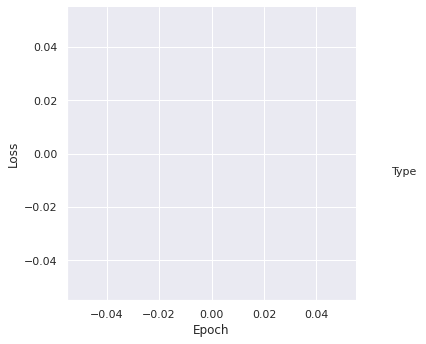

In [41]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result_84))

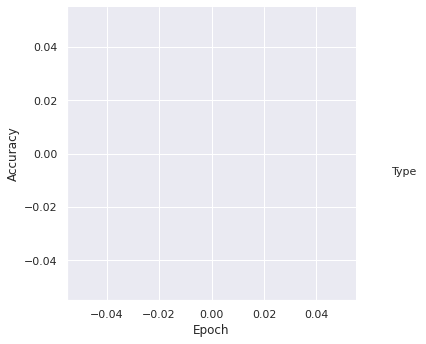

In [42]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result_84))

## [85. 双方向RNN・多層化](https://nlp100.github.io/ja/ch09.html#85-%E5%8F%8C%E6%96%B9%E5%90%91rnn%E5%A4%9A%E5%B1%A4%E5%8C%96)
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．
$$
\overleftarrow{h}_{T+1} = 0, \overleftarrow{h}_t = \overleftarrow{\mathrm{RNN}}(\mathrm{emb}(x_t), \overleftarrow{h}_{t+1}), y = \mathrm{softmax}(W^{(yh)} [\overrightarrow{h}_T; \overleftarrow{h}_1] + b^{(y)})
$$
ただし，$\overrightarrow{h}_t \in \mathbb{R}^{d_h}, \overleftarrow{h}_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，$\overleftarrow{\mathrm{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．

In [43]:
random.seed(85)
np.random.seed(85)
torch.manual_seed(85)
if torch.cuda.is_available():
    torch.cuda.manual_seed(85)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [44]:
V = len(word2count) + 1 # +1は出現回数1回のID番号0の分を追加している
d_w = 300
d_h = 100
num_layers = 3

In [45]:
class Network85(torch.nn.Module):
    def __init__(self):
        super(Network85, self).__init__()

        # (batch,T,V) -> (batch,T,d_w)
        self.emb = torch.nn.Embedding(num_embeddings=V,
                                      embedding_dim=d_w)
        # (batch,T,d_w), (2*num_layers,batch,d_h) -> (batch,T,2*d_h), (2*num_layers,batch,d_h)
        self.rnn = torch.nn.RNN(input_size=d_w,
                                hidden_size=d_h,
                                num_layers=num_layers,
                                batch_first=True,
                                bidirectional=True)
        # (batch,2*d_h) -> (batch,4)
        self.affine = torch.nn.Linear(in_features=2*d_h,
                                      out_features=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, h0):
        # (batch,T) -> (batch,T,d_w)
        x = self.emb(x)
        # (batch,T,d_w), (2*num_layers,batch,d_h) -> (batch,T,2*d_h), (2*num_layers,batch,d_h)
        _, hn = self.rnn(x, h0)
        # (2*num_layers,batch,d_h) -> (num_layers,2,batch,d_h) -> (2,batch,d_h)
        x = hn.view(num_layers, 2, h0.shape[1], d_h)[-1]
        # (2,batch,d_h) -> (batch,2*d_h)
        x = torch.cat([x[0], x[1]], 1)
        # (batch,2*d_h) -> (batch,4)
        x = self.affine(x)
        return self.log_softmax(x)

In [46]:
network85, epoch, batch_size, lr = Network85().to(device), 20, 32, 0.05
loader85_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader85_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [47]:
%%time
result85 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network85.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader85_train:
        network85.zero_grad()
        h0 = torch.zeros(6, x_in.shape[0], d_h).to(device)
        x_out = network85(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result85["Epoch"].append(e)
    result85["Type"].append("Training")
    result85["Loss"].append(loss_sum)
    result85["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader85_valid:
        network85.zero_grad()
        h0 = torch.zeros(6, 1, d_h).to(device)
        x_out = network85(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result85["Epoch"].append(e)
    result85["Type"].append("Validation")
    result85["Loss"].append(loss_sum)
    result85["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/20,Loss:1130.964,Training Accuracy:63.05%,Validation Accuracy:68.64%
Epoch:2/20,Loss:1033.783,Training Accuracy:74.42%,Validation Accuracy:72.53%
Epoch:3/20,Loss:969.592,Training Accuracy:79.49%,Validation Accuracy:73.65%
Epoch:4/20,Loss:929.028,Training Accuracy:83.94%,Validation Accuracy:75.15%
Epoch:5/20,Loss:839.920,Training Accuracy:88.06%,Validation Accuracy:79.12%
Epoch:6/20,Loss:920.432,Training Accuracy:91.16%,Validation Accuracy:78.29%
Epoch:7/20,Loss:1153.881,Training Accuracy:93.72%,Validation Accuracy:77.54%
Epoch:8/20,Loss:988.316,Training Accuracy:95.50%,Validation Accuracy:79.49%
Epoch:9/20,Loss:1177.335,Training Accuracy:97.01%,Validation Accuracy:79.04%
Epoch:10/20,Loss:1136.745,Training Accuracy:97.79%,Validation Accuracy:80.76%
Epoch:11/20,Loss:1241.870,Training Accuracy:98.65%,Validation Accuracy:80.54%
Epoch:12/20,Loss:1211.865,Training Accuracy:99.36%,Validation Accuracy:81.59%
Epoch:13/20,Loss:1198.443,Training Accuracy:99.82%,Validation Accuracy:82.41%


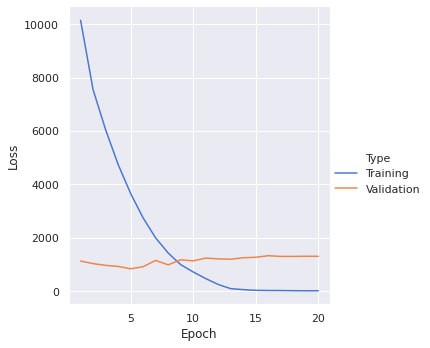

In [48]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result85))

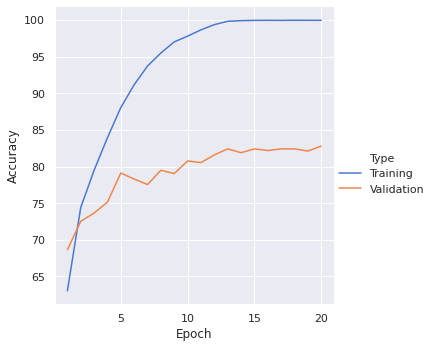

In [49]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result85))

## [86. 畳み込みニューラルネットワーク (CNN)](https://nlp100.github.io/ja/ch09.html#86-%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF-cnn)
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．
+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現

すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．
$$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$$
ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．

最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．
$$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$$
最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．
$$
y = \mathrm{softmax}(W^{(yc)} c + b^{(y)})
$$
なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

In [50]:
class Network86(torch.nn.Module):
    def __init__(self):
        super(Network86, self).__init__()

        # (batch,T,V) -> (batch,T,d_w)
        self.emb = torch.nn.Embedding(num_embeddings=V,
                                      embedding_dim=d_w)
        # (batch,d_w,T) -> (batch,d_h,T)
        self.conv = torch.nn.Conv1d(in_channels=d_w,
                                    out_channels=d_h,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1,
                                    dilation=1,
                                    bias=True)
        self.tanh = torch.nn.Tanh()
        # (batch,d_h) -> (batch,4)
        self.affine = torch.nn.Linear(in_features=d_h,
                                      out_features=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # (batch,T) -> (batch,T,d_w)
        x = self.emb(x)
        # (batch,T,d_w) -> (batch,d_w,T)
        x = x.permute(0, 2, 1)
        # (batch,d_w,T) -> (batch,d_h,T)
        x = self.conv(x)
        x = self.tanh(x)
        # (batch,d_h,T) -> (batch,d_h)
        x = x.max(2)[0]
        # (batch,d_h) -> (batch,4)
        x = self.affine(x)
        return self.log_softmax(x)

In [51]:
network86 = Network86()

In [52]:
for x_in, _ in torch.utils.data.DataLoader(dataset81_test, batch_size=1):
    x_out = network86(x_in)
    y = torch.exp(x_out)
    print(y)
    break

tensor([[0.1985, 0.2858, 0.2242, 0.2915]], grad_fn=<ExpBackward>)


## [87. 確率的勾配降下法によるCNNの学習](https://nlp100.github.io/ja/ch09.html#87-%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95%E3%81%AB%E3%82%88%E3%82%8Bcnn%E3%81%AE%E5%AD%A6%E7%BF%92)
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [53]:
random.seed(87)
np.random.seed(87)
torch.manual_seed(87)
if torch.cuda.is_available():
    torch.cuda.manual_seed(87)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [54]:
network87, epoch, batch_size, lr = Network86().to(device), 10, 32, 0.05
loader87_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader87_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [55]:
%%time
result87 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network87.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader87_train:
        network87.zero_grad()
        x_out = network87(x_in.to(device))
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result87["Epoch"].append(e)
    result87["Type"].append("Training")
    result87["Loss"].append(loss_sum)
    result87["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader87_valid:
        network87.zero_grad()
        x_out = network87(x_in.to(device))
        loss = criterion(x_out, y.to(device))

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result87["Epoch"].append(e)
    result87["Type"].append("Validation")
    result87["Loss"].append(loss_sum)
    result87["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/10,Loss:1031.112,Training Accuracy:67.16%,Validation Accuracy:72.23%
Epoch:2/10,Loss:861.830,Training Accuracy:79.21%,Validation Accuracy:75.82%
Epoch:3/10,Loss:770.474,Training Accuracy:88.87%,Validation Accuracy:79.12%
Epoch:4/10,Loss:743.997,Training Accuracy:94.92%,Validation Accuracy:79.72%
Epoch:5/10,Loss:723.246,Training Accuracy:98.55%,Validation Accuracy:81.21%
Epoch:6/10,Loss:736.243,Training Accuracy:99.76%,Validation Accuracy:80.84%
Epoch:7/10,Loss:740.977,Training Accuracy:99.91%,Validation Accuracy:81.44%
Epoch:8/10,Loss:751.087,Training Accuracy:99.93%,Validation Accuracy:81.44%
Epoch:9/10,Loss:765.326,Training Accuracy:99.93%,Validation Accuracy:81.06%
Epoch:10/10,Loss:772.096,Training Accuracy:99.96%,Validation Accuracy:81.21%
CPU times: user 16.8 s, sys: 185 ms, total: 17 s
Wall time: 17.1 s


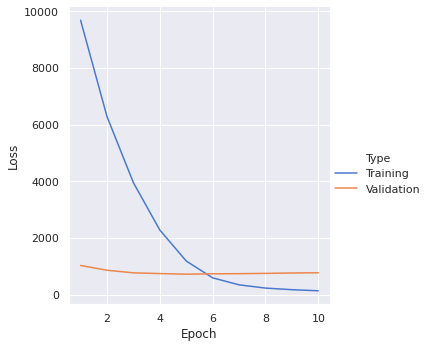

In [56]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result87))

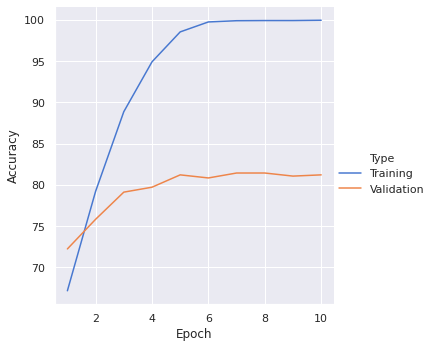

In [57]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result87))

## [88. パラメータチューニング](https://nlp100.github.io/ja/ch09.html#88-%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0)
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [58]:
random.seed(88)
np.random.seed(88)
torch.manual_seed(88)
if torch.cuda.is_available():
    torch.cuda.manual_seed(88)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [59]:
V = len(word2count) + 1 # +1は出現回数1回のID番号0の分を追加している
d_w = 300
d_h = 100
num_layers = 3
dropout_prob = 0.2

In [60]:
class Network88(torch.nn.Module):
    def __init__(self):
        super(Network88, self).__init__()

        # (batch,T,V) -> (batch,T,d_w)
        self.emb = torch.nn.Embedding(num_embeddings=V,
                                      embedding_dim=d_w)
        # (batch,T,d_w), ((2*num_layers,batch,d_h),(2*num_layers,batch,d_h))
        # -> (batch,T,2*d_h), ((2*num_layers,batch,d_h),(2*num_layers,batch,d_h))
        self.lstm = torch.nn.LSTM(input_size=d_w,
                                  hidden_size=d_h,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  dropout=dropout_prob,
                                  bidirectional=True)
        # (batch,2*d_h) -> (batch,4)
        self.affine = torch.nn.Linear(in_features=2*d_h,
                                      out_features=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, hc):
        # (batch,T) -> (batch,T,d_w)
        x = self.emb(x)
        # (batch,T,d_w), ((2*num_layers,batch,d_h),(2*num_layers,batch,d_h))
        # -> (batch,T,2*d_h), ((2*num_layers,batch,d_h),(2*num_layers,batch,d_h))
        _, (hn, _) = self.lstm(x, hc)
        # (2*num_layers,batch,d_h) -> (num_layers,2,batch,d_h) -> (2,batch,d_h)
        x = hn.view(num_layers, 2, h0.shape[1], d_h)[-1]
        # (2,batch,d_h) -> (batch,2*d_h)
        x = torch.cat([x[0], x[1]], 1)
        # (batch,2*d_h) -> (batch,4)
        x = self.affine(x)
        return self.log_softmax(x)

In [61]:
network88, epoch, batch_size = Network88().to(device), 10, 32
loader88_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader88_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [62]:
%%time
result88 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network88.parameters())
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader88_train:
        network88.zero_grad()
        h0 = torch.zeros(2*num_layers, x_in.shape[0], d_h).to(device)
        c0 = torch.zeros(2*num_layers, x_in.shape[0], d_h).to(device)
        x_out = network88(x_in.to(device), (h0,c0))
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result88["Epoch"].append(e)
    result88["Type"].append("Training")
    result88["Loss"].append(loss_sum)
    result88["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader88_valid:
        network88.zero_grad()
        h0 = torch.zeros(2*num_layers, 1, d_h).to(device)
        c0 = torch.zeros(2*num_layers, 1, d_h).to(device)
        x_out = network88(x_in.to(device), (h0,c0))
        loss = criterion(x_out, y.to(device))

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result88["Epoch"].append(e)
    result88["Type"].append("Validation")
    result88["Loss"].append(loss_sum)
    result88["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/10,Loss:666.166,Training Accuracy:74.13%,Validation Accuracy:82.41%
Epoch:2/10,Loss:558.064,Training Accuracy:88.60%,Validation Accuracy:85.63%
Epoch:3/10,Loss:561.923,Training Accuracy:94.87%,Validation Accuracy:86.45%
Epoch:4/10,Loss:579.980,Training Accuracy:97.33%,Validation Accuracy:87.28%
Epoch:5/10,Loss:609.920,Training Accuracy:98.66%,Validation Accuracy:88.70%
Epoch:6/10,Loss:679.581,Training Accuracy:98.92%,Validation Accuracy:88.77%
Epoch:7/10,Loss:706.356,Training Accuracy:99.33%,Validation Accuracy:88.17%
Epoch:8/10,Loss:950.102,Training Accuracy:99.47%,Validation Accuracy:86.75%
Epoch:9/10,Loss:883.106,Training Accuracy:99.50%,Validation Accuracy:87.87%
Epoch:10/10,Loss:821.234,Training Accuracy:99.62%,Validation Accuracy:88.62%
CPU times: user 1min 8s, sys: 1.17 s, total: 1min 9s
Wall time: 1min 9s


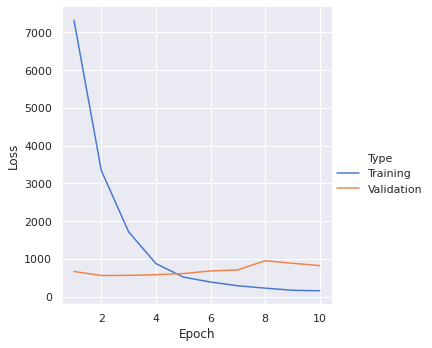

In [63]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result88))

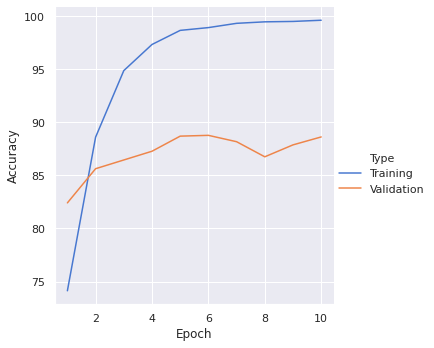

In [64]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result88))

## [89. 事前学習済み言語モデルからの転移学習](https://nlp100.github.io/ja/ch09.html#89-%E4%BA%8B%E5%89%8D%E5%AD%A6%E7%BF%92%E6%B8%88%E3%81%BF%E8%A8%80%E8%AA%9E%E3%83%A2%E3%83%87%E3%83%AB%E3%81%8B%E3%82%89%E3%81%AE%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92)
事前学習済み言語モデル（例えば[BERT](https://github.com/google-research/bert)など）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [65]:
from pytorch_transformers import BertForSequenceClassification

In [66]:
random.seed(89)
np.random.seed(89)
torch.manual_seed(89)
if torch.cuda.is_available():
    torch.cuda.manual_seed(89)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [67]:
# 事前学習済の「Embedding層+BERT12層」の後に、Dropout層とAffine層を追加し、
# Embedding層、および、Affine層のみ転移学習する
network89 = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                          output_attentions=False,
                                                          output_hidden_states=False,
                                                          num_labels=4).to(device)
for param in network89.bert.encoder.parameters():
    param.requires_grad = False

In [68]:
epoch, batch_size = 5, 32
loader89_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader89_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [69]:
%%time
result89 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network89.parameters())
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader89_train:
        network89.zero_grad()
        loss, logits = network89(x_in.to(device),
                                 labels=y.to(device),
                                 token_type_ids=None,
                                 attention_mask=None)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(logits, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result89["Epoch"].append(e)
    result89["Type"].append("Training")
    result89["Loss"].append(loss_sum)
    result89["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader89_valid:
        network89.zero_grad()
        loss, logits = network89(x_in.to(device),
                                 labels=y.to(device),
                                 token_type_ids=None,
                                 attention_mask=None)

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(logits, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result89["Epoch"].append(e)
    result89["Type"].append("Validation")
    result89["Loss"].append(loss_sum)
    result89["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/5,Loss:492.133,Training Accuracy:80.26%,Validation Accuracy:87.65%
Epoch:2/5,Loss:452.799,Training Accuracy:94.37%,Validation Accuracy:89.15%
Epoch:3/5,Loss:720.175,Training Accuracy:97.89%,Validation Accuracy:87.35%
Epoch:4/5,Loss:702.290,Training Accuracy:98.82%,Validation Accuracy:87.80%
Epoch:5/5,Loss:840.976,Training Accuracy:99.34%,Validation Accuracy:87.87%
CPU times: user 3min 42s, sys: 430 ms, total: 3min 42s
Wall time: 3min 43s


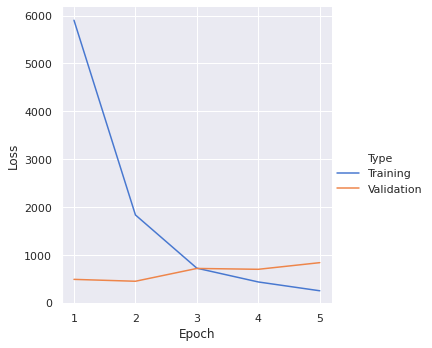

In [70]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result89))

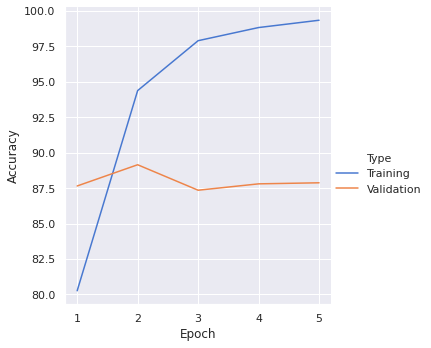

In [71]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result89))